In [6]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import statsmodels.api as sm
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import lars_path

%matplotlib inline
sns.set()

In [7]:
with open('../feature_engineering/video_channel_df_8162_fin.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [8]:
df.columns

Index(['views_video', 'video_order_num', 'duration_sec', 'likes', 'dislikes',
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc', 'channel_URL', 'channel_name'],
      dtype='object')

In [9]:
X_array = df.loc[:,'video_order_num':'sentiment_score_video_desc'].values.reshape(-1, 1)
X_df = df[['video_order_num', 'duration_sec', 'likes', 'dislikes',
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc']]
y = df['views_video']

## Baseline linear regression

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y, 
                                                    test_size=0.3, 
                                                    random_state=42)

vanilla_LR = LinearRegression()
vanilla_LR.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [39]:
vanilla_LR.score(X_train,y_train) 

0.9597382729266982

In [40]:
vanilla_LR.score(X_test,y_test)

0.7475116440993992

## Regularizing, keeping Original Features

In [41]:
std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train)
X_te = std.transform(X_test)#numpy.ndarray

In [42]:
alphavec = 10**np.linspace(-6,4,200)
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train);

In [43]:
lasso_model.score(X_tr,y_train)

0.9596720678574545

In [44]:
lasso_model.alpha_

10000.0

In [45]:
lasso_model.score(X_te,y_test) ##doesnt work as it is about variation in the data, 

0.7487661708655377

## Adding Channel Level Aggrigative Features

In [46]:
df_channel_video_history = (df
 .groupby(['channel_URL'])[['views_video', 'video_order_num', 'video_desc_length', 
                            'likes', 'dislikes', 'duration_sec', 
                            'video_age_days', 'sentiment_score_video_desc']]
 .agg({
     'views_video':'mean',
     'video_order_num':'count',
     'video_desc_length': 'mean',
     'likes':'sum',
     'dislikes':'sum',
     'duration_sec':'mean',
     'video_age_days':'mean',
     'sentiment_score_video_desc':'mean'
     
 })
)

In [48]:
df = df.join(df_channel_video_history, on='channel_URL', how='left', rsuffix='_history')

In [49]:
df.columns

Index(['views_video', 'video_order_num', 'duration_sec', 'likes', 'dislikes',
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc', 'channel_URL', 'channel_name',
       'views_video_history', 'video_order_num_history',
       'video_desc_length_history', 'likes_history', 'dislikes_history',
       'duration_sec_history', 'video_age_days_history',
       'sentiment_score_video_desc_history'],
      dtype='object')

In [52]:
df.rename(columns={'views_video_history':'views_video_hist_mean',
                   'video_order_num_history':'video_order_num_hist_count',
                   'video_desc_length_history':'video_desc_length_hist_mean', 
                   'likes_history':'likes_hist_sum', 
                   'dislikes_history':'dislikes_hist_sum',
                   'duration_sec_history':'duration_sec_hist_mean', 
                   'video_age_days_history':'video_age_days_hist_mean',
                   'sentiment_score_video_desc_history':'sentiment_score_video_desc_hist_mean'}, 
          inplace=True)

In [54]:
df.columns

Index(['views_video', 'video_order_num', 'duration_sec', 'likes', 'dislikes',
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc', 'channel_URL', 'channel_name',
       'views_video_hist_mean', 'video_order_num_hist_count',
       'video_desc_length_hist_mean', 'likes_hist_sum', 'dislikes_hist_sum',
       'duration_sec_hist_mean', 'video_age_days_hist_mean',
       'sentiment_score_video_desc_hist_mean'],
      dtype='object')

## Add polynomial and interaction terms 

In [57]:
X_array_h = df.loc[:,['video_order_num', 'duration_sec', 'likes', 'dislikes',
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc',
       'views_video_hist_mean', 'video_order_num_hist_count',
       'video_desc_length_hist_mean', 'likes_hist_sum', 'dislikes_hist_sum',
       'duration_sec_hist_mean', 'video_age_days_hist_mean',
       'sentiment_score_video_desc_hist_mean']].values.reshape(-1, 1)

X_df_h = df[['video_order_num', 'duration_sec', 'likes', 'dislikes',
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc',
       'views_video_hist_mean', 'video_order_num_hist_count',
       'video_desc_length_hist_mean', 'likes_hist_sum', 'dislikes_hist_sum',
       'duration_sec_hist_mean', 'video_age_days_hist_mean',
       'sentiment_score_video_desc_hist_mean']]

y_h = df['views_video']

In [58]:
pf = PolynomialFeatures(degree=2)
orig_features_h = X_df_h.columns
pf.fit(df[orig_features_h])

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')

In [59]:
feat_array_h = pf.transform(df[orig_features_h])
feat_array_h = pd.DataFrame(feat_array_h, columns = pf.get_feature_names(input_features=orig_features_h))

In [64]:
X_train, X_test, y_train, y_test = train_test_split(feat_array_h, y_h, 
                                                    test_size=0.3, 
                                                    random_state=42)
model_w_poly_feat_h = LinearRegression()
model_w_poly_feat_h.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [65]:
model_w_poly_feat_h.score(X_train,y_train)

0.9965608803465577

In [66]:
model_w_poly_feat_h.score(X_test,y_test) #overfit alert! regularize

-2.2976078488820093

In [78]:
std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train)
X_te = std.transform(X_test)#numpy.ndarray
alphavec = 10**np.linspace(-10,10,200)
lasso_model_w_poly_feat_h = LassoCV(alphas = alphavec, cv=5)
lasso_model_w_poly_feat_h.fit(X_tr, y_train);

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15818146860779.75, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13520364330641.75, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15494347884527.0, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergenc

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131373153580959.3, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132252208693214.75, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132974365424088.36, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136101026693998.22, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136068231427562.31, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136036249138703.23, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Conver

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135445565395041.62, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135432427212762.4, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135419651815142.03, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135165679759600.53, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135159178099525.88, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135152797420707.89, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Conver

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 208779282572421.25, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215945920102023.7, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 235898948303777.38, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 333188372494950.06, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 333054892735064.6, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 332914206648994.5, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converge

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 329465992831598.6, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 329363149934197.7, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 329262418343876.94, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converge

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 327196005811712.1, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 327139083405524.94, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 327083283685474.44, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325924327654112.0, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325891874611936.56, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325860024456295.3, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converge

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 317501718135569.5, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 322818416769396.94, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 327644921715528.75, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348584167883280.4, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348466592054891.2, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348348687244093.75, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converge

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345839579597373.9, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345778679948100.44, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345719323373783.7, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converge

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 344526249934801.2, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 344495798910339.3, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 344465934725507.7, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergen

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194780339873692.7, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 214677296524979.2, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 230053311305578.75, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converge

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315438515226334.44, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315390089195354.5, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315330516918173.94, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313248695215040.75, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313192993575938.5, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313138529253817.2, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converge

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 311963070224068.94, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 311929714268547.4, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 311896771795860.06, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 311105503494829.75, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23798779237805.25, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79072374370676.38, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converge

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 308892221320668.1, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 309405997306816.06, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 309812561514430.8, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converge

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 309446511194606.94, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 309375883919738.25, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 309306463382767.56, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Conver

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 307720552992392.0, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 307672971466728.94, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 307625837833462.7, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converge

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 306450104016649.44, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 306412238495105.75, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 306374604535629.3, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

In [79]:
lasso_model_w_poly_feat_h.score(X_tr,y_train) ##note:ridge gives slightly worse result

0.9892881419367454

In [80]:
lasso_model_w_poly_feat_h.alpha_

47137.53134116729

In [81]:
lasso_model_w_poly_feat_h.score(X_te,y_test)

0.7735661621041386

In [71]:
coefs = list(zip(X_train.columns, lasso_model_w_poly_feat_h.coef_))

In [72]:
df_coefs = pd.DataFrame(coefs, columns=['variable', 'coefficient'])
df_coefs

,variable,coefficient
0,1,0.000000e+00
1,video_order_num,-0.000000e+00
2,duration_sec,-0.000000e+00
3,likes,6.881796e+05
4,dislikes,2.557667e+06
...,...,...
320,duration_sec_hist_mean video_age_days_hist_mean,0.000000e+00
321,duration_sec_hist_mean sentiment_score_video_d...,0.000000e+00
322,video_age_days_hist_mean^2,0.000000e+00
323,video_age_days_hist_mean sentiment_score_video...,0.000000e+00


In [73]:
df_coefs[df_coefs['coefficient']>0.0]

,variable,coefficient
3,likes,6.881796e+05
4,dislikes,2.557667e+06
17,views_video_hist_mean,5.153976e+05
72,likes^2,5.869755e+04
82,likes delivery_method_Published,6.969510e+05
86,likes views_video_hist_mean,1.645623e+06
99,dislikes n_promo_links,1.716566e+05
100,dislikes channel_desc_length,8.606568e+05
291,views_video_hist_mean video_desc_length_hist_mean,2.445311e+05


In [ ]:
#95, 74 --> #99,77

## Model2: Remove variables that we do not have for new video

Inspect

In [83]:
df_nolidisl = df.drop(['likes', 'dislikes','channel_URL', 'channel_name'], axis=1)

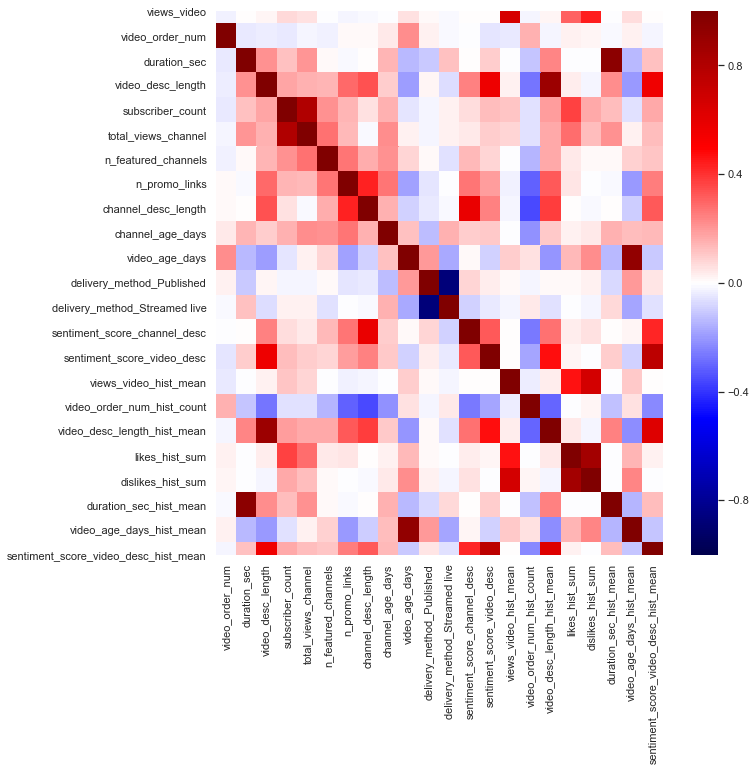

In [84]:
plt.figure(figsize=[10,10])
sns.heatmap(df_nolidisl.corr(), square=False, cmap="seismic", annot=False,  vmin=-1, vmax=1)
plt.gca().set_xlim(1);

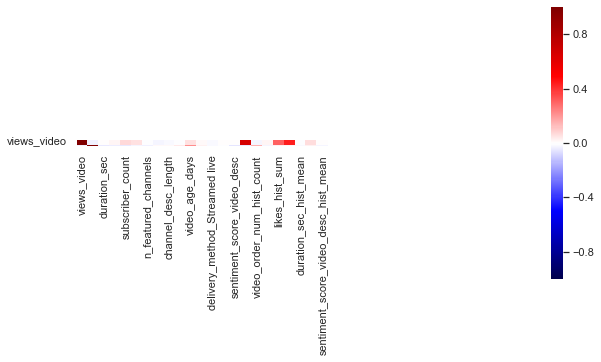

In [86]:
plt.figure(figsize=[10,10])
sns.heatmap(df_nolidisl.corr(), 
            cmap="seismic", annot=False,  vmin=-1, vmax=1, square=True, 
            cbar_kws = dict(orientation = 'vertical', shrink =0.5, pad =0.4, aspect=22))
#ax_divider
#plt.gca().set_ylim(len(df_no_outliers_history_nolidisl.corr())+0.5, -0.5);
plt.gca().set_ylim(1);
#plt.gca().set_xlim(1);

Model

In [87]:
#removing likes and dislikes
X_array_h_rem_likes = df.loc[:,['video_order_num', 'duration_sec', 
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc',
       'views_video_hist_mean', 'video_order_num_hist_count',
       'video_desc_length_hist_mean', 'likes_hist_sum', 'dislikes_hist_sum',
       'duration_sec_hist_mean', 'video_age_days_hist_mean',
       'sentiment_score_video_desc_hist_mean']].values.reshape(-1, 1)

X_df_h_rem_likes = df[['video_order_num', 'duration_sec', 
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc',
       'views_video_hist_mean', 'video_order_num_hist_count',
       'video_desc_length_hist_mean', 'likes_hist_sum', 'dislikes_hist_sum',
       'duration_sec_hist_mean', 'video_age_days_hist_mean',
       'sentiment_score_video_desc_hist_mean']]

y_h_rem_likes = df['views_video']

In [89]:
pf = PolynomialFeatures(degree=2)
orig_features_h_rem_likes = X_df_h_rem_likes.columns
pf.fit(df[orig_features_h_rem_likes])

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')

In [90]:
feat_array_h_rem_likes = pf.transform(df[orig_features_h_rem_likes])
feat_array_h_rem_likes = pd.DataFrame(feat_array_h_rem_likes, columns = pf.get_feature_names(input_features=orig_features_h_rem_likes))

In [92]:
X_train, X_test, y_train, y_test = train_test_split(feat_array_h_rem_likes, y_h_rem_likes, 
                                                    test_size=0.3, 
                                                    random_state=42)
model_w_poly_feat_h_rem_likes = LinearRegression()
model_w_poly_feat_h_rem_likes.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [94]:
model_w_poly_feat_h_rem_likes.score(X_train,y_train)

0.671638781800988

In [95]:
model_w_poly_feat_h_rem_likes.score(X_test,y_test) #overfit alert! regularize

-9.499030390134314

In [99]:
std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train)
X_te = std.transform(X_test)#numpy.ndarray
alphavec = 10**np.linspace(-10,10,200)
lasso_model_w_poly_feat_h_rem_likes = LassoCV(alphas = alphavec, cv=5)
lasso_model_w_poly_feat_h_rem_likes.fit(X_tr, y_train);

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19599608201604.0, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25765724241300.0, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59302553368228.0, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceW

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7911207134787742.0, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7944314450329032.0, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7970969814778413.0, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Conver

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8084956915998584.0, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8084950482828151.0, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8084934558977320.0, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Conver

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8083815880830439.0, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8083775004101764.0, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8083734400337640.0, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Conver

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8082548612838639.0, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8082514804201565.0, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8082481194950219.0, tolerance: 12176542010624.873
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Conver

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.967927121071455e+16, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1130197280261736e+16, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.220842418281048e+16, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:4

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.806109852759295e+16, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8061801543742376e+16, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.80622134650925e+16, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:47

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.805133703145957e+16, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.805101091508053e+16, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.805069449359295e+16, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:47

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.804422739043907e+16, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8044090287173e+16, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.804395605287977e+16, tolerance: 23392375457484.418
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471:

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7520838963369040.0, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9780814449695408.0, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9348692319770736.0, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Conver

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.939510243726257e+16, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.940960603067914e+16, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.942126519048883e+16, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:47

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9465738985070916e+16, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9465657169824668e+16, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9465572914484132e+16, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9463762728386456e+16, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9463722091925256e+16, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.946368262169834e+16, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.946288300981721e+16, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.946286348266768e+16, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9462844317188268e+16, tolerance: 20969933730686.914
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:4

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6578900503683336e+16, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.826554273466624e+16, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.976932418421062e+16, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:4

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2492213851189404e+16, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.250051511991183e+16, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2507130014168708e+16, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2527554621912292e+16, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2527402246556324e+16, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2527254438815892e+16, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2524410594383612e+16, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2524359855453896e+16, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.252431045765842e+16, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.252336454053206e+16, tolerance: 21464940299066.387
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 235887012295744.0, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196471180884144.0, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Conve

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.605239998649462e+16, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.631330603918923e+16, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6526222547376376e+16, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:4

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.744806804577759e+16, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7448382827153656e+16, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.744856045843004e+16, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:4

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7443003932693784e+16, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.744279789849121e+16, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.744259729737743e+16, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:4

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.743831562063138e+16, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7438229660568856e+16, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.743814573906259e+16, tolerance: 16369611550599.105
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:4

In [100]:
lasso_model_w_poly_feat_h_rem_likes.score(X_tr,y_train) 

0.666688557751496

In [101]:
lasso_model_w_poly_feat_h_rem_likes.alpha_

365.4383070957262

In [102]:
lasso_model_w_poly_feat_h_rem_likes.score(X_te,y_test)

-3.178889940934759

In [103]:
#coefs = list(zip(X_train.columns, lasso_model_w_poly_feat_h.coef_))

In [106]:
#df_coefs = pd.DataFrame(coefs, columns=['variable', 'coefficient'])
#df_coefs

In [107]:
#df_coefs[df_coefs['coefficient']>0.0]

Conclusion: one cannot predict views without likes/dislikes or other features. 

## Study Influence of Outliers on Best Model

In [111]:
df['res'] = abs(vanilla_LR.predict(X_df)-df['views_video'])

In [112]:
df['res'].describe()

count    8.162000e+03
mean     2.197852e+05
std      1.230999e+06
min      2.785025e+01
25%      3.631629e+04
50%      7.971599e+04
75%      1.460839e+05
max      5.814060e+07
Name: res, dtype: float64

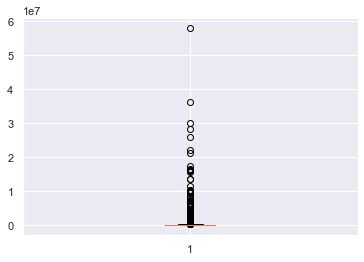

In [113]:
plt.boxplot(df['res']);

In [84]:
#outliers in terms of residuals
df[df['res'] > 1.233987e+07]

,views_video,video_order_num,duration_sec,likes,dislikes,video_desc_length,subscriber_count,total_views_channel,n_featured_channels,n_promo_links,channel_desc_length,channel_age_days,video_age_days,delivery_method_Published,delivery_method_Streamed live,sentiment_score_channel_desc,sentiment_score_video_desc,channel_URL,channel_name,res
video_id,,,,,,,,,,,,,,,,,,,,
cnKZit6VB44,274881305.0,3.0,616.0,216457.0,13039.0,644.0,670000.0,59473573.0,2.0,4.0,721.0,3462.0,2005.0,1,0,22.0,7.0,https://www.youtube.com/user/shilpayoga,Shilpa Shetty Kundra,3.633791e+07
8uAz-0ADqd4,52743498.0,30.0,52.0,28300.0,1373.0,1036.0,670000.0,59473573.0,2.0,4.0,721.0,3462.0,3060.0,1,0,22.0,18.0,https://www.youtube.com/user/shilpayoga,Shilpa Shetty Kundra,1.594711e+07
46ND9G6sGNw,15212610.0,23.0,399.0,991.0,34.0,187.0,0.0,182645.0,0.0,3.0,197.0,4788.0,3857.0,1,0,2.0,12.0,https://www.youtube.com/user/stephkittell,WEBSITE,1.376085e+07
KpGv0tmP4E8,40390416.0,8.0,295.0,4387.0,1448.0,358.0,32300.0,7815228.0,0.0,6.0,791.0,2772.0,2456.0,1,0,9.0,9.0,https://www.youtube.com/user/zaoyoga,ZaoYoga,2.124439e+07
6j4jm8Xf86U,4431841.0,23.0,273.0,21910.0,1572.0,764.0,90200.0,14038606.0,0.0,0.0,17.0,2969.0,460.0,0,0,0.0,5.0,https://www.youtube.com/channel/UCA04EYY6ZDiLW...,,3.008210e+07
oqCqPnMtQ1I,15847556.0,12.0,385.0,43.0,1.0,90.0,5780.0,1642065.0,0.0,0.0,0.0,2443.0,2443.0,1,0,0.0,0.0,https://www.youtube.com/channel/UC0bvNaJz9MPNW...,,1.558105e+07
sXSzAeOADbE,30871111.0,23.0,1500.0,15905.0,166.0,3074.0,101000.0,2327723.0,0.0,2.0,963.0,649.0,344.0,1,0,-2.0,-5.0,https://www.youtube.com/channel/UCod2Gi9j8THW1...,Fotos e Dicas de Yoga!,1.649857e+07
cNn2svpM_mU,18497011.0,2.0,60.0,1315.0,91.0,73.0,1740.0,245968.0,0.0,0.0,120.0,1206.0,353.0,1,0,1.0,0.0,https://www.youtube.com/channel/UCOsPqobaY6odj...,,1.644463e+07
TQr6c07N5cE,34892210.0,1.0,251.0,4711.0,222.0,1446.0,0.0,29174939.0,0.0,0.0,261.0,644.0,328.0,0,0,0.0,-3.0,https://www.youtube.com/channel/UC4dlco6FzS-AJ...,,2.828677e+07


In [85]:
df_no_outliers = df[df['res'] < 1.233987e+07]  ## keep 6

In [86]:
df_no_outliers.shape ##removed 181 observations with greatest residual values 

(8147, 20)

In [87]:
X_array_no_outliers = df_no_outliers.loc[:,'video_order_num':'sentiment_score_video_desc'].values.reshape(-1, 1)
X_df_no_outliers = df_no_outliers[['video_order_num', 'duration_sec', 'likes', 'dislikes',
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc']]
y_no_outliers = df_no_outliers['views_video']

## Baseline Regression with Outliers Removed

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X_df_no_outliers, 
                                                    y_no_outliers, 
                                                    test_size=0.33, 
                                                    random_state=42)

In [91]:
vanilla_LR_no = LinearRegression()
vanilla_LR_no.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [92]:
vanilla_LR_no.score(X_train,y_train) #--> outliers

0.9020243619504923

In [93]:
vanilla_LR_no.score(X_test,y_test)

0.9790659767868498

## New Features Engineering

Polynomial

In [99]:
pf = PolynomialFeatures(degree=2)

In [102]:
orig_features = X_df_no_outliers.columns
pf.fit(df_no_outliers[orig_features])

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')

In [103]:
feat_array = pf.transform(df_no_outliers[orig_features])
#feat_array = pd.DataFrame(feat_array, columns = pf.get_feature_names(input_features=orig_features))

In [104]:
#y = df_no_outliers['views_video']

In [105]:
X_train, X_test, y_train, y_test = train_test_split(feat_array, y_no_outliers, test_size=0.33, random_state=42)
model_w_poly_feat = LinearRegression()
model_w_poly_feat.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [106]:
model_w_poly_feat.score(X_train,y_train)

0.9439757068163651

In [107]:
model_w_poly_feat.score(X_test,y_test)

0.9533797286449197

In [110]:
std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train)
X_te = std.transform(X_test)#numpy.ndarray
alphavec = 10**np.linspace(-2,7,200)
lasso_model_w_poly_feat = LassoCV(alphas = alphavec, cv=5)
lasso_model_w_poly_feat.fit(X_tr, y_train);

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1553897784257.625, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1531415718627.25, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1094672767132.0, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarn

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83121495414336.19, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92401780203773.5, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100604717980847.47, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceW

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172305942633652.53, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 173182041941343.9, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 173982567528419.56, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergenc

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 182444320832381.72, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 182539547216987.47, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 182629862531546.94, tolerance: 886899827717.6106
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergen

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5428573273121.4375, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9611921025748.656, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13057953740831.438, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergenc

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96564635681266.25, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98839224856676.4, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100942903009809.0, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWa

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130107921942324.94, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130715428774290.4, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131281981666086.77, tolerance: 915264695154.9686
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergenc

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15462018783769.625, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21461061624140.375, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27284040372292.75, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWa

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145463512201011.22, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 147373784054114.9, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 149122593764075.12, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWa

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 169318652912584.28, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 169480213335831.5, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 169627277869185.94, tolerance: 887536278476.872
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWa

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3541723892010.625, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3570046965688.6875, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3631563424535.5, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWa

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88278804303377.12, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91296100739007.1, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94040144405018.92, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWa

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121347856311002.2, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121498750250613.53, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121635193271771.47, tolerance: 728619339492.3666
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergenc

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 435408478940.5, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 598142482273.0, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 822186479903.625, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning:

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34683954764466.344, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38526576507840.69, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43110891770233.81, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergence

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114244922486197.06, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114922607892799.77, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115525838629306.52, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergen

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 124722051309896.12, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 124803623989042.27, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 124886272593899.45, tolerance: 403925585457.7961
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergen

In [111]:
lasso_model_w_poly_feat.score(X_tr,y_train)

0.9400812614533199

In [112]:
lasso_model_w_poly_feat.alpha_

11489.510001873086

In [113]:
lasso_model_w_poly_feat.score(X_te,y_test)

0.9092048487301712